# Solve the Eikonal with many number of points with SWIM

This notebook aims to test SWIM-PDE collecting more measurament from the differential problem

In [1]:
# Import required libraries

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

from Eikonal_groundtruth import *

In [2]:
x_span = -2, 2
n_dim = 2
noise_level = 0

Generate the ground-truth data

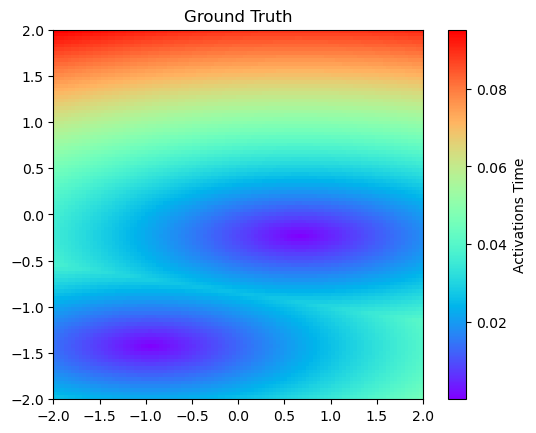

In [3]:
u_true = anysotropic_FMM_fast(x0, y0, t0, x1, y1, t1, Cv, r)

plt.imshow(u_true, extent=[*x_span, *x_span], origin="lower", cmap="rainbow")
plt.colorbar(label="Activations Time")  # orientation="horizontal"
plt.title("Ground Truth")
plt.show()

Collects measuraments from the ground truth

In [4]:
n_measurement_points = 300

rng = np.random.default_rng(10)
xy_measurement = rng.uniform(*x_span, size=(n_measurement_points, n_dim))

x = np.linspace(-2, 2, 101)
y = np.linspace(-2, 2, 101)

interp = RegularGridInterpolator((x, y), u_true.T) 

u_measured = interp(xy_measurement)

noise = rng.normal(size=n_measurement_points) * noise_level
u_measured = u_measured * (1 + noise)
u_measured = u_measured.reshape(-1, 1)

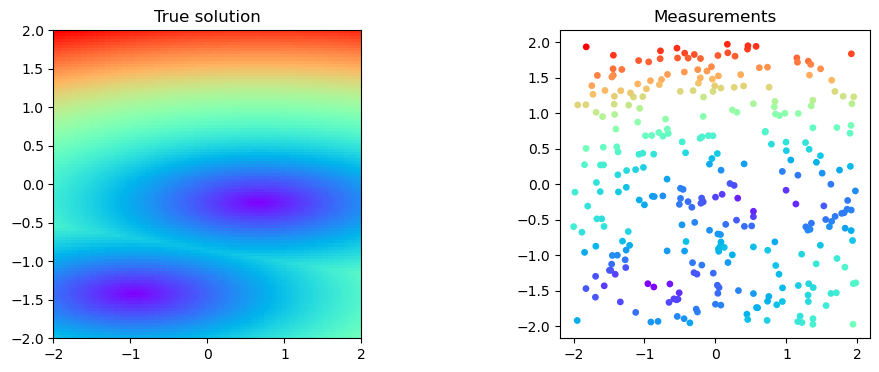

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot the test data.
axes[0].imshow(u_true, extent=[*x_span, *x_span], origin="lower", cmap="rainbow")
axes[0].set_title("True solution")

# Plot the measurements.
axes[1].scatter(*xy_measurement.T, c=u_measured, s=15, cmap = "rainbow")
axes[1].set_title("Measurements");
axes[1].set_aspect("equal")

Start the SWIM-PDE set up

In [6]:
# Import libraries
from functools import partial
from time import time

import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline

from swimnetworks import Linear
from swimpde.ansatz import BasicAnsatz
from swimpde.domain import Domain

In [7]:
# Phisics data
a_ratio = 8.8131
Cv = 75.2629
theta_fiber = 0
theta0 = np.pi/2 - theta_fiber
a = np.array([np.cos(theta0), np.sin(theta0)]).T
b = np.array([np.cos(theta0-np.pi/2), np.sin(theta0-np.pi/2)]).T
D = ( (1/a_ratio)*np.tensordot( a, a,  axes=0) + np.tensordot( b, b,  axes=0)  )

# Phisics forcing
def forcing(v):
    return -np.ones((v.shape[0],1))

# Evaluation data to test the results on.
n_test_sqrt = 101
x_span = -2, 2
n_dim = 2

x_test = np.linspace(*x_span, num=n_test_sqrt)
y_test = np.linspace(*x_span, num=n_test_sqrt)
xy_test = np.stack(np.meshgrid(x_test, y_test), axis=-1)
xy_test = xy_test.reshape(-1, n_dim)

In [8]:
# Swim model
def get_model(points, target, n_basis, seed):
    domain = Domain(interior_points=points)
    ansatz = BasicAnsatz(n_basis=n_basis,
                        activation="tanh",
                        random_seed=seed)
    ansatz.fit(domain, target)
    linear = Linear(regularization_scale=1e-12)
    if target is not None:
        weights = np.linalg.lstsq(
            ansatz.transform(points), target, rcond=1e-12
            )[0]
        linear.weights = weights
    linear.biases = np.zeros((1, 1))
    linear.layer_width = 1
    return ansatz, linear

In [9]:
def swim_train (xy_measurement, u_measured):

    # Collocation points
    n_col_sqrt = 30

    x_col = np.linspace(*x_span, num=n_col_sqrt)
    y_col = np.linspace(*x_span, num=n_col_sqrt)
    xy_col = np.stack(np.meshgrid(x_col, y_col), axis=-1)
    xy_col = xy_col.reshape(-1, n_dim)

    # Model parameters
    n_basis = 800
    u_seed = 99

    u_ansatz, u_linear = get_model(xy_measurement, u_measured, n_basis, u_seed)

    forcing_col = forcing(xy_col)
    training_start = time()
    
    u_phi_measured = u_ansatz.transform(xy_measurement)
    u_phi_x = u_ansatz.transform(xy_col, operator="gradient")


    # Least squares for computing u_approx: use updated value of gamma
    # and also stack the true values we know at the measurement points
    matrix_in_u = Cv * np.sqrt(np.einsum("nkd,df,nkf->nk", u_phi_x, D, u_phi_x))
        
    matrix_in_u = np.row_stack([matrix_in_u, u_phi_measured])
    matrix_out_u = np.concatenate([forcing_col, u_measured])

    u_outer_weights = np.linalg.lstsq(matrix_in_u, matrix_out_u, rcond=1e-12)[0]

    u_linear.weights = u_outer_weights

    training_time = time() - training_start
    print(f"Training time: {training_time}")

    u_model = Pipeline([("ansatz", u_ansatz), ("linear", u_linear)])
    u_pred = u_model.transform(xy_test).ravel()

    return u_pred

In [10]:
u_pred = swim_train(xy_measurement, u_measured)

/tmp/ipykernel_12610/2909697182.py:28: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  matrix_in_u = np.row_stack([matrix_in_u, u_phi_measured])


Training time: 1.022916316986084


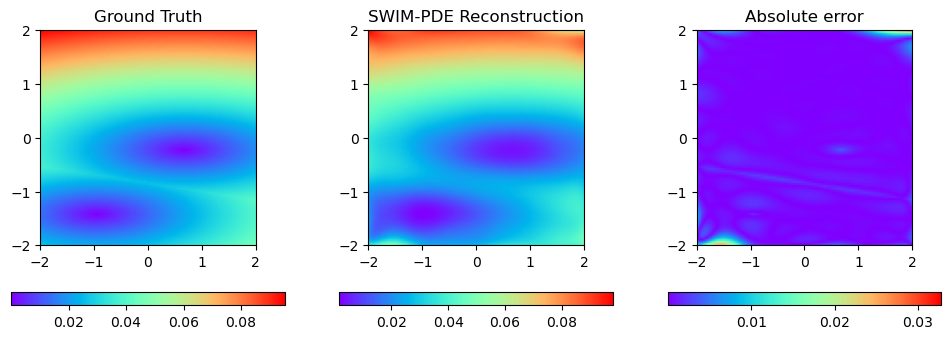

In [11]:
# Visualize predictions of u
data = {"Ground Truth": u_true,
        "SWIM-PDE Reconstruction": u_pred,
        "Absolute error": np.abs(u_true.reshape(-1) - u_pred.ravel())}

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, label in zip(axes, data):
    squared = data[label].reshape(n_test_sqrt, n_test_sqrt)
    im = ax.imshow(squared, extent=[*x_span, *x_span], origin="lower", cmap = "rainbow")
    ax.set_title(label)
    fig.colorbar(im, ax=ax, orientation="horizontal")

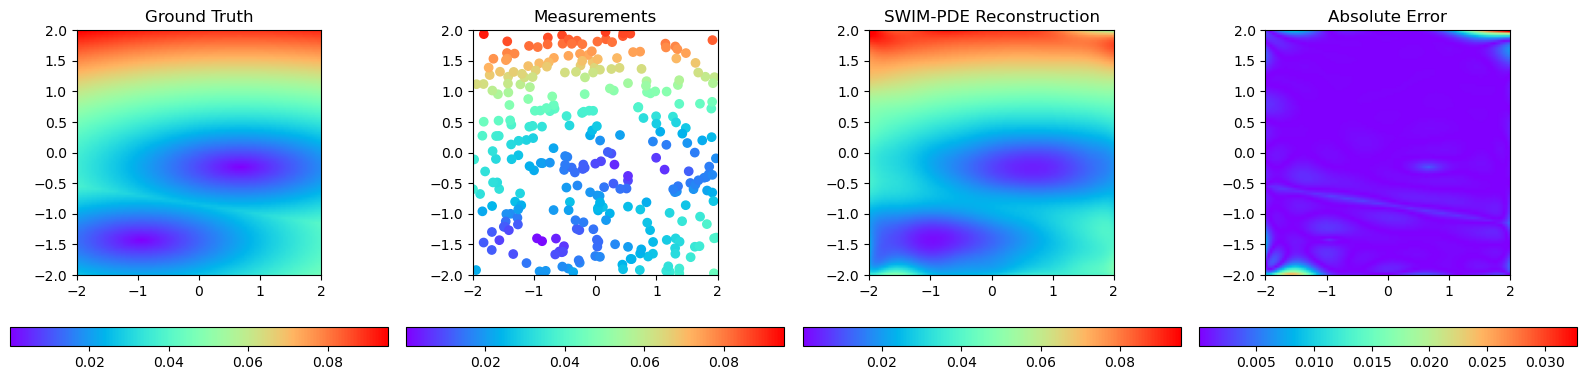

In [12]:
vmin = np.min(u_true)
vmax = np.max(u_true)

data = {
    "Ground Truth": u_true,
    "SWIM-PDE Reconstruction": u_pred,
    "Absolute error": np.abs(u_true.reshape(-1) - u_pred),
}

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Plot 1 - Ground Truth
squared = data["Ground Truth"].reshape(101, 101)
im0 = axes[0].imshow(squared, extent=[*x_span, *x_span], origin="lower", cmap="rainbow", vmin=vmin, vmax=vmax)
axes[0].set_title("Ground Truth")
fig.colorbar(im0, ax=axes[0], orientation="horizontal")

# Plot 2 - Measurements (scatterplot)
scatter = axes[1].scatter(xy_measurement[:, 0], xy_measurement[:, 1], c=u_measured, cmap="rainbow", vmin=vmin, vmax=vmax)
axes[1].set_title("Measurements")
axes[1].set_xlim(-2, 2)
axes[1].set_ylim(-2, 2)
axes[1].set_aspect("equal")
fig.colorbar(scatter, ax=axes[1], orientation="horizontal")

# Plot 3 - PINN Reconstruction
squared = data["SWIM-PDE Reconstruction"].reshape(101, 101)
im2 = axes[2].imshow(squared, extent=[*x_span, *x_span], origin="lower", cmap="rainbow", vmin=vmin, vmax=vmax)
axes[2].set_title("SWIM-PDE Reconstruction")
fig.colorbar(im2, ax=axes[2], orientation="horizontal")

# Plot 4 - Absolute Error (con scala diversa)
squared = data["Absolute error"].reshape(101, 101)
im3 = axes[3].imshow(squared, extent=[*x_span, *x_span], origin="lower", cmap="rainbow")
axes[3].set_title("Absolute Error")
fig.colorbar(im3, ax=axes[3], orientation="horizontal")

plt.tight_layout()
plt.show()
